# Week 7 Data acqusition from OpenBCI

In [12]:
# import require library for preprocess
import mne
import numpy as np
from mne.channels import make_standard_montage
import matplotlib.pyplot as plt
from mne.datasets import eegbci
import scipy
import pickle
import seaborn as sns
from scipy.signal import filtfilt
import pyxdf

# import require library for classification
from sklearn.svm import SVC # SVM library
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # LDA library
from sklearn.neighbors import KNeighborsClassifier # KNN library

from sklearn.metrics import classification_report,confusion_matrix # Result representation

# OPENBCI

## 1 Read recorded data from OpenBCI (bdf file)

In [13]:
import pyxdf
import mne
import numpy as np
streams, header = pyxdf.load_xdf("data/OpenBCI_data.xdf") #Example Data from Lab Recoder

if streams[0]['info']['type'][0] == 'Markers': #Check
    raw_stream = streams[1]
    event_data = streams[0]
else:
    raw_stream = streams[0]
    event_data = streams[1]

raw_data = raw_stream["time_series"].T #From Steam variable this query is EEG data
channels = ['CH1','CH2','CH3','CH4','CH5','CH6','CH7','CH8'] #Set your target EEG channel name
info = mne.create_info(
    ch_names= channels,
    ch_types= ['eeg']*len(channels),
    sfreq= 250 #OpenBCI Frequency acquistion
)
raw_OpenBCI = mne.io.RawArray(raw_data, info, verbose=False)    


In [14]:
raw_OpenBCI

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


In [15]:
raw_OpenBCI.ch_names

['CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6', 'CH7', 'CH8']

## 2. Filter

Effective window size : 8.192 (s)


C:\Users\pipo_\AppData\Local\Temp\ipykernel_20348\4197467807.py:1: UserWarning: Zero value in spectrum for channels CH7, CH8
  raw_OpenBCI.compute_psd(fmax=60).plot(picks=raw_OpenBCI.ch_names[0:5])
C:\Users\pipo_\AppData\Local\Temp\ipykernel_20348\4197467807.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_OpenBCI.compute_psd(fmax=60).plot(picks=raw_OpenBCI.ch_names[0:5])
c:\git\BCI-Class-Material\.venv\Lib\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


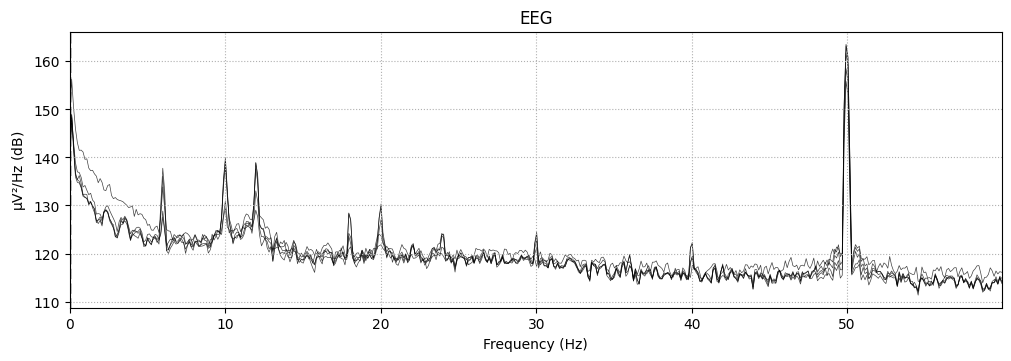

In [16]:
raw_OpenBCI.compute_psd(fmax=60).plot(picks=raw_OpenBCI.ch_names[0:5])
plt.show()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge

C:\Users\pipo_\AppData\Local\Temp\ipykernel_20348\2478548851.py:3: UserWarning: Zero value in spectrum for channels CH7, CH8
  OpenBCI_filter.compute_psd(fmax=60).plot(picks=raw_OpenBCI.ch_names[0:5])
C:\Users\pipo_\AppData\Local\Temp\ipykernel_20348\2478548851.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  OpenBCI_filter.compute_psd(fmax=60).plot(picks=raw_OpenBCI.ch_names[0:5])
c:\git\BCI-Class-Material\.venv\Lib\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


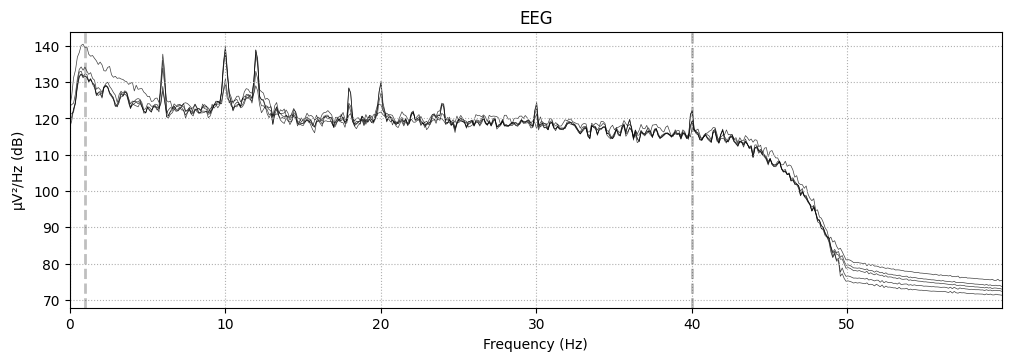

In [17]:
OpenBCI_filter = raw_OpenBCI.copy().filter(l_freq=1, h_freq=40) #band-pass function
OpenBCI_filter = OpenBCI_filter.copy().notch_filter(freqs=50) #notch filter function
OpenBCI_filter.compute_psd(fmax=60).plot(picks=raw_OpenBCI.ch_names[0:5])
plt.show()

## 3.Epoching

In [18]:
sfreq= 250
event_index = np.array(event_data["time_series"]).T[0] #Get all event marker of experiment 
event_timestamp = (np.array(event_data["time_stamps"]).T * sfreq) - (raw_stream['time_stamps'][0] * sfreq) #Timestamp when event marked

In [19]:
events2 = np.column_stack((np.array(event_timestamp, dtype = int),
                        np.zeros(len(event_timestamp), dtype = int),
                        np.array(event_index, dtype = int)))

events_id2 = { # Set up your event name
     'Left cue start': 1,
     'Left stimuli start': 2,
     'Left blank start': 3,
     'Right cue start': 4,
     'Right stimuli start': 5,
     'Right blank start' : 6,
}

In [20]:
events2

array([[  803,     0,     4],
       [ 1173,     0,     5],
       [ 3673,     0,     6],
       [ 3799,     0,     1],
       [ 4173,     0,     2],
       [ 6677,     0,     3],
       [ 6798,     0,     4],
       [ 7173,     0,     5],
       [ 9673,     0,     6],
       [ 9802,     0,     1],
       [10177,     0,     2],
       [12677,     0,     3],
       [12798,     0,     1],
       [13178,     0,     2],
       [15673,     0,     3],
       [15798,     0,     4],
       [16173,     0,     5],
       [18673,     0,     6],
       [18798,     0,     1],
       [19177,     0,     2],
       [21673,     0,     3],
       [21798,     0,     4],
       [22173,     0,     5],
       [24673,     0,     6],
       [24798,     0,     1],
       [25181,     0,     2],
       [27673,     0,     3],
       [27802,     0,     4],
       [28173,     0,     5],
       [30673,     0,     6],
       [30801,     0,     4],
       [31178,     0,     5],
       [33673,     0,     6],
       [33

In [21]:
OpenBCI_epochs = mne.Epochs(OpenBCI_filter, events2, 
        tmin= -0.5,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax= 1.5,    # final timestamp (10 means set epoch duration 10 second)
        event_id =events_id2,
        preload = True,
        event_repeated='drop',
        baseline=(-0.5, 0)
    )

Not setting metadata
48 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 501 original time points ...
0 bad epochs dropped


In [22]:
OpenBCI_epochs

Number of events,48
Events,Left blank start: 8Left cue start: 8Left stimuli start: 8Right blank start: 8Right cue start: 8Right stimuli start: 8
Time range,-0.500 – 1.500 s
Baseline,-0.500 – 0.000 s


Using matplotlib as 2D backend.


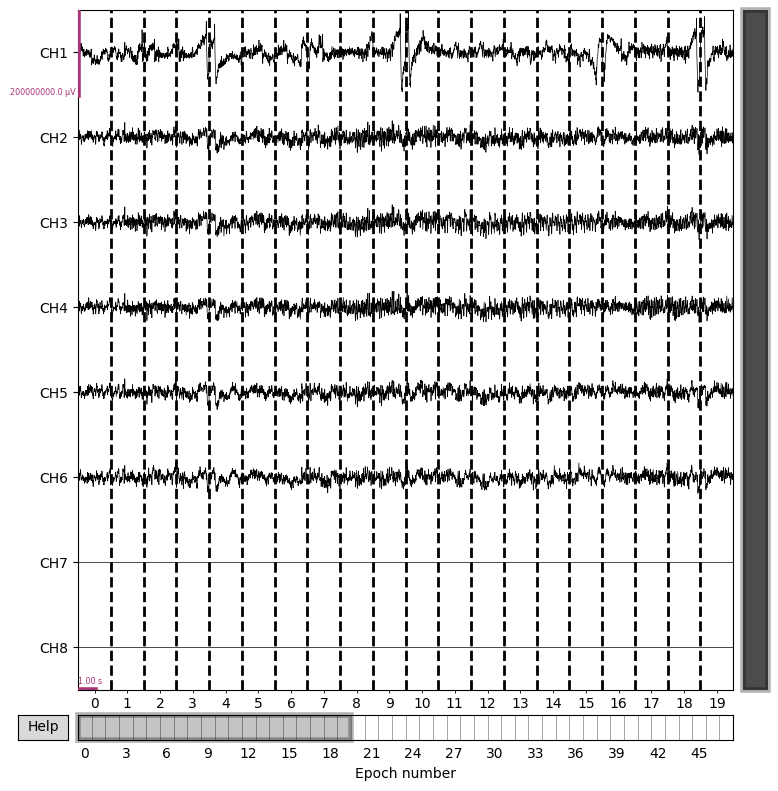

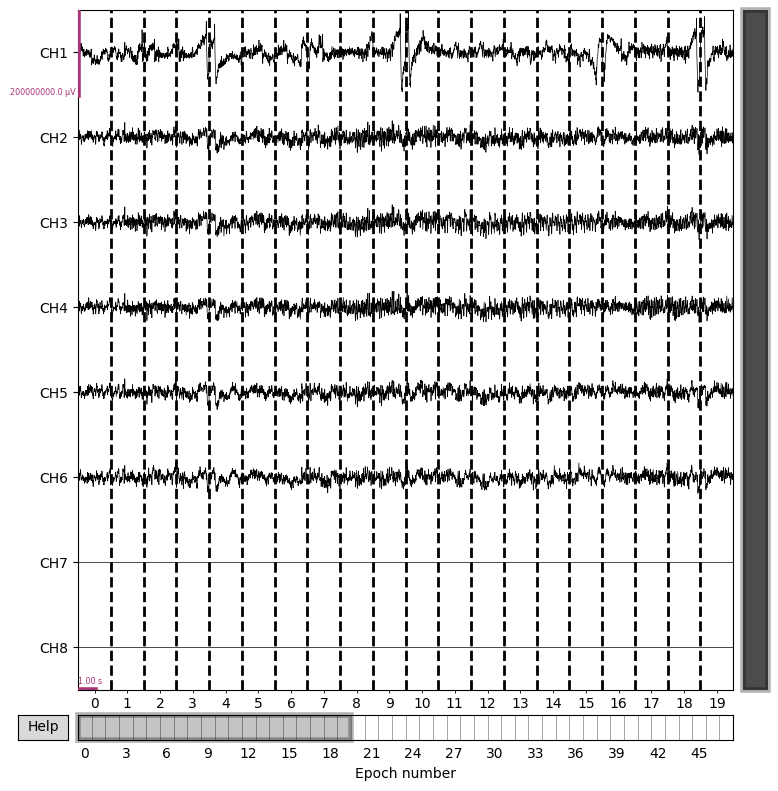

In [23]:
OpenBCI_epochs.plot(scalings = 100)